# Extract boxes with PyTorch

In [1]:
# !pip uninstall -y imgaug && pip install -U imgaug

In [2]:
%load_ext autoreload
%autoreload 2

import os, glob, json, tqdm, pandas
import matplotlib.pyplot as plt
%pylab inline

import torch
from torch import nn
from torch.autograd import Variable
from torch.nn import functional as F
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader

from imgaug import augmenters as iaa
from imgaug import imgaug as ia
from PIL import Image

from IPython.display import display

from prepare_images_utils import *
from latex_dataset import *

Populating the interactive namespace from numpy and matplotlib


## Prepare data source

In [3]:
SRC_DIR = './generated/src/'

In [4]:
all_image_ids = [os.path.basename(fname)[:-9]
                 for fname in glob.glob(os.path.join(SRC_DIR, '*_out.json'))]
random.shuffle(all_image_ids)

TOTAL_SAMPLES = len(all_image_ids)
TRAIN_SAMPLES = int(TOTAL_SAMPLES * 0.8)
VAL_SAMPLES = TOTAL_SAMPLES - TRAIN_SAMPLES
train_image_ids = all_image_ids[:TRAIN_SAMPLES]
val_image_ids = all_image_ids[TRAIN_SAMPLES:]

In [5]:
def load_image_with_boxes(img_id):
    img = load_image_opaque(os.path.join(SRC_DIR, img_id + '_in.png'))
    with open(os.path.join(SRC_DIR, img_id + '_out.json'), 'r') as f:
        boxes = json.load(f)
    return img, boxes


def prepare_img_boxes_for_nn(img, boxes, shape=(600, 600)):
    cats, just_boxes = zip(*boxes)
    cats = numpy.array(cats)
    just_boxes = numpy.array(just_boxes) * POINTS_TO_PIXELS_FACTOR
    just_boxes = just_boxes[:, [1, 0, 3, 2]] # x1, y1, x2, y2
    cropbox = numpy.array((just_boxes[:, 0].min(),
                           just_boxes[:, 1].min(),
                           just_boxes[:, 2].max(),
                           just_boxes[:, 3].max())).astype('int')

    res_in_img = Image.new('L', shape, 255)
    res_in_img.paste(img.crop(cropbox))

    just_boxes -= cropbox[[0, 1, 0, 1]]
    just_boxes = numpy.clip(just_boxes,
                            (0, 0, 0, 0),
                            (shape[0], shape[1], shape[0], shape[1]))
    boxes_area = (just_boxes[:, 2] - just_boxes[:, 0]) * (just_boxes[:, 3] - just_boxes[:, 1])
    good_boxes = numpy.where(boxes_area > 0)[0]
    return (numpy.array(res_in_img).astype('float32') / 255,
            cats[good_boxes],
            just_boxes[good_boxes])


TOTAL_CLASSES = 5
def make_mask_for_nn(size, box_cats, boxes_on_image):
    result = numpy.zeros((TOTAL_CLASSES, ) + size, dtype='float32')
    for cat, bbox in zip(box_cats, boxes_on_image.bounding_boxes):
        result[cat, int(bbox.y1):int(bbox.y2+1), int(bbox.x1):int(bbox.x2+1)] = 1
    return result


def calc_loss_weights(mask, edge_add_weight=0.5, laplacian_ksize=5):
    result = numpy.ones_like(mask)
    for sample_i in range(mask.shape[0]):
        for channel_i in range(mask.shape[1]):
            edges = numpy.absolute(cv2.Laplacian(mask[sample_i, channel_i],
                                                 cv2.CV_32F,
                                                 ksize=laplacian_ksize))
            if edges.max() > 0:
                result[sample_i, channel_i] += (edge_add_weight * edges / edges.max())
    return result


def prepare_batch(batch_image_ids, augmenter):
    images, box_cats, boxes = zip(*[prepare_img_boxes_for_nn(*load_image_with_boxes(img_id))
                                    for img_id in batch_image_ids])

    det = augmenter.to_deterministic() if not augmenter.deterministic else augseq

    images_aug = det.augment_images(images)

    boxes = [ia.BoundingBoxesOnImage([ia.BoundingBox(*box)
                                      for box in img_boxes],
                                     img.shape)
             for img, img_boxes in zip(images, boxes)]
    boxes_aug = det.augment_bounding_boxes(boxes)

    mask = numpy.array([make_mask_for_nn(img.shape, img_box_cats, img_boxes)
                        for img, img_box_cats, img_boxes
                        in zip(images_aug, box_cats, boxes_aug)])
    boxes_aug_lists = [[[b.x1, b.y1, b.x2, b.y2]
                        for b in img_boxes.bounding_boxes]
                       for img_boxes in boxes_aug]
    return (batch_image_ids,
            numpy.expand_dims(numpy.array(images_aug), 1),
            mask,
            calc_loss_weights(mask),
            boxes_aug_lists)


def data_gen(image_ids, augmenter, batch_size=32):
    while True:
        yield prepare_batch(numpy.random.choice(image_ids, size=batch_size),
                            augmenter)


class SegmDataset(Dataset):
    def __init__(self, all_image_ids, augmenter):
        self.all_image_ids = all_image_ids
        self.augmenter = augmenter

    def __len__(self):
        return len(self.all_image_ids)

    def __getitem__(self, i):
        (batch_image_ids,
         in_img,
         mask,
         loss_weights,
         boxes_aug) = prepare_batch([self.all_image_ids[i]],
                                    self.augmenter)
        return (batch_image_ids,
                in_img[0],
                mask[0],
                loss_weights[0],
                boxes_aug[0])

In [6]:
imgaug_pipeline = iaa.Sequential([
#     iaa.Fliplr(0.5), # horizontally flip 50% of the images
#     iaa.GaussianBlur(sigma=(0, 3.0)) # blur images with a sigma of 0 to 3.0
])

### Compare data generators

In [7]:
# train_gen_mt = DataLoader(SegmDataset(train_image_ids, imgaug_pipeline),
#                           batch_size=8,
#                           shuffle=True,
#                           num_workers=4)
# train_gen_mt_iter = iter(train_gen_mt)
# _ = next(train_gen_mt_iter)

In [8]:
# %%prun
# for _ in range(10):
#     next(train_gen_mt_iter)

In [9]:
# train_gen_st = data_gen(train_image_ids, imgaug_pipeline, batch_size=8)
# train_gen_st_iter = iter(train_gen_st)
# _ = next(train_gen_st_iter)

In [10]:
# %%prun
# for _ in range(10):
#     next(train_gen_st_iter)

## Define a network

In [11]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilations=[1], padding=1, bn=True):
        super(ConvBlock, self).__init__()
        self.bn = nn.BatchNorm2d(in_channels)
        self.convs = nn.ModuleList([nn.Conv2d(in_channels,
                                              out_channels,
                                              kernel_size,
                                              padding=padding,
                                              dilation=dil)
                                    for dil in dilations])

    def forward(self, x):
        x = self.bn(x)
        return F.relu(torch.cat([conv(x) for conv in self.convs], dim=1))


class UNet(nn.Module):
    def __init__(self, out_channels=TOTAL_CLASSES, first_conv_channels=4, depth=2, out_layers=1, conv_kernel=(3, 3),
                 enc_dilations=[1], dec_dilations=[1]):
        super(UNet, self).__init__()
        enc_channels = [1] + [first_conv_channels * (2**step) for step in range(depth)]
        self.encoder = nn.ModuleList([ConvBlock(enc_channels[i],
                                                enc_channels[i+1],
                                                conv_kernel,
                                                dilations=enc_dilations)
                                      for i in range(depth)])
        bottleneck_channels = enc_channels[-1] * 2
        self.bottleneck = ConvBlock(enc_channels[-1],
                                    bottleneck_channels,
                                    conv_kernel,
                                    dilations=enc_dilations)
        dec_channels = [bottleneck_channels] + enc_channels[:0:-1]
        self.dec_conv = nn.ModuleList([ConvBlock(dec_channels[i],
                                                 dec_channels[i+1],
                                                 conv_kernel,
                                                 dilations=dec_dilations)
                                      for i in range(depth)])
        self.dec_deconv = nn.ModuleList([nn.ConvTranspose2d(dec_channels[i],
                                                            dec_channels[i+1],
                                                            (2, 2),
                                                            stride=2)
                                         for i in range(depth)])
        self.out_layers = nn.ModuleList([ConvBlock(dec_channels[-1],
                                                   dec_channels[-1],
                                                   conv_kernel,
                                                   dilations=dec_dilations)])
        self.out_conv = nn.Conv2d(dec_channels[-1],
                                  out_channels,
                                  (1, 1))

    def forward(self, x):
        enc_conv_outs = []
        enc_pool_outs = [x]
        for enc_conv in self.encoder:
            cur_conv_out = enc_conv(enc_pool_outs[-1])
            enc_conv_outs.append(cur_conv_out)
            cur_pool_out = F.max_pool2d(cur_conv_out, (2, 2))
            enc_pool_outs.append(cur_pool_out)

        cur_out = self.bottleneck(enc_pool_outs[-1])

        for dec_step, (dec_conv, dec_deconv) in enumerate(zip(self.dec_conv, self.dec_deconv)):
            up = dec_deconv(cur_out)
            cur_out = torch.cat([up, enc_conv_outs[-dec_step-1]], dim=1)
            cur_out = dec_conv(cur_out)

        for out_layer in self.out_layers:
            cur_out = F.relu(out_layer(cur_out))

        return F.sigmoid(self.out_conv(cur_out))

## Define losses and metrics

In [12]:
DICE_SMOOTH = 1.0
def dice_coef(pred, target):
    intersection = pred * target
    union = pred + target
    return ((2. * intersection.sum(3).sum(2).sum(0) + DICE_SMOOTH) /
            (union.sum(3).sum(2).sum(0) + DICE_SMOOTH))


def dice_loss(pred, target, weights):
    intersection = pred * target
    union = pred + target
    return 1 - ((2. * intersection.sum() + DICE_SMOOTH) /
                (union.sum() + DICE_SMOOTH))


def dice_bce_loss(pred, target, weights):
    return dice_loss(pred, target, weights) + F.binary_cross_entropy(pred, target, weights)


def px_precision(pred, target, threshold=0.5):
    pred = pred >= threshold
    target = target >= threshold
    tp = (pred * target).float().sum(3).sum(2).sum(0)
    fp = ((target - pred) < 0).float().sum(3).sum(2).sum(0)
    denum = tp + fp
    return tp / (denum + (denum == 0).float())


def px_recall(pred, target, threshold=0.5):
    pred = pred >= threshold
    target = target >= threshold
    tp = (pred * target).float().sum(3).sum(2).sum(0)
    fn = ((pred - target) < 0).float().sum(3).sum(2).sum(0)
    denum = tp + fn
    return tp / (denum + (denum == 0).float())


def make_single_channel(f, channel):
    def _impl(pred, target):
        return f(pred[:, channel:channel+1], target[:, channel:channel+1])
    return _impl


def make_cpu(f):
    def _impl(pred, target):
        return f(pred.cpu(), target.cpu())
    return _impl


METRICS = {'d' : dice_coef,
#            'p' : px_precision,
#            'r' : px_recall
           }
# for channel in range(1, TOTAL_CLASSES):
#     METRICS['d{}'.format(channel)] = make_single_channel(make_cpu(dice_coef), channel)
#     METRICS['pp{}'.format(channel)] = make_single_channel(px_precision, channel)
#     METRICS['pr{}'.format(channel)] = make_single_channel(px_recall, channel)

## Train

In [13]:
def mcuda(x, cuda):
    return x.cuda() if cuda else x


def npten(arr, cuda):
    return mcuda(torch.from_numpy(arr), cuda)


def npvar(arr, cuda):
    if not torch.is_tensor(arr):
        arr = torch.from_numpy(arr)
    return mcuda(Variable(arr), cuda)


def run_network(network, generator, num_batches, criterion=dice_bce_loss, optimizer=None, cuda=True):
    metrics = []
    gen_iter = iter(generator)
    for _ in tqdm.tqdm(range(num_batches)):
        image_ids, images, mask, loss_weights, boxes = next(gen_iter)
        images_var = npvar(images, cuda)
        mask_var = npvar(mask, cuda)
        loss_weights_var = npvar(loss_weights, cuda)

        cur_out = network(images_var)

        loss = criterion(cur_out, mask_var, loss_weights_var)

        if optimizer:
            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm(network.parameters(), 10)
            optimizer.step()

        cur_metrics = { 'loss' : loss.data[0] }
        for name, func in METRICS.items():
            metric_value = func(cur_out, mask_var).cpu().data.numpy()
            cur_metrics.update((name+str(i), v) for i, v in enumerate(metric_value))
        metrics.append(cur_metrics)
    return metrics

In [21]:
train_gen = None
val_gen = None

EPOCHS_NUM = 10
BATCH_SIZE = 16
PART_PER_EPOCH = 0.5
BATCHES_PER_EPOCH_TRAIN = int(len(train_image_ids) * PART_PER_EPOCH / BATCH_SIZE)
BATCHES_PER_EPOCH_VAL = int(len(val_image_ids) * PART_PER_EPOCH // BATCH_SIZE)

# train_gen = data_gen(train_image_ids, imgaug_pipeline, batch_size=BATCH_SIZE)
# val_gen = data_gen(val_image_ids, imgaug_pipeline, batch_size=BATCH_SIZE)


net = UNet(first_conv_channels=
           8, depth=3, enc_dilations=[1]).cuda()
optimizer = Adam(net.parameters())
# LOSS = dice_bce_loss
LOSS = dice_loss
print('total parameters', sum(numpy.product(p.size()) for p in net.parameters()))

train_metrics = []
val_metrics = []
for epoch in range(EPOCHS_NUM):
    try:
        train_gen = DataLoader(SegmDataset(train_image_ids, imgaug_pipeline),
                       batch_size=BATCH_SIZE,
                       shuffle=True,
                       num_workers=4)
        val_gen = DataLoader(SegmDataset(val_image_ids, imgaug_pipeline),
                             batch_size=BATCH_SIZE,
                             shuffle=True,
                             num_workers=2)
        print('epoch', epoch)
        net.train()
        cur_train_metrics = run_network(net, train_gen, BATCHES_PER_EPOCH_TRAIN,
                                        criterion=LOSS,
                                        optimizer=optimizer)
        train_metrics.extend(cur_train_metrics)
        display(pandas.DataFrame(cur_train_metrics).describe().loc[['mean', 'std']])

        net.eval()
        cur_val_metrics = run_network(net, val_gen, BATCHES_PER_EPOCH_VAL,
                                      criterion=LOSS)
        val_metrics.extend(cur_val_metrics)
        display(pandas.DataFrame(cur_val_metrics).describe().loc[['mean', 'std']])
    finally:
        if train_gen:
            del train_gen
        if val_gen:
            del val_gen

total parameters 60423
epoch 0


100%|██████████| 75/75 [00:43<00:00,  1.73it/s]


,d0,d1,d2,d3,d4,loss
mean,3.374127e-07,0.359100,0.143432,0.218034,0.394024,0.766358
std,1.242093e-08,0.103942,0.056998,0.070101,0.113981,0.071102


100%|██████████| 18/18 [00:09<00:00,  1.83it/s]


,d0,d1,d2,d3,d4,loss
mean,3.507792e-07,0.553894,0.305354,0.406690,0.720904,0.610206
std,5.394165e-09,0.026763,0.010138,0.018714,0.019906,0.020961


epoch 1


100%|██████████| 75/75 [00:45<00:00,  1.65it/s]


,d0,d1,d2,d3,d4,loss
mean,7.332580e-07,0.756553,0.398196,0.546629,0.830876,0.457510
std,4.367341e-07,0.136755,0.074319,0.098725,0.086073,0.114095


100%|██████████| 18/18 [00:10<00:00,  1.75it/s]


,d0,d1,d2,d3,d4,loss
mean,2.121326e-06,0.940658,0.494240,0.667814,0.908768,0.271829
std,3.408192e-08,0.006691,0.010693,0.010866,0.005640,0.008189


epoch 2


100%|██████████| 75/75 [00:47<00:00,  1.58it/s]


,d0,d1,d2,d3,d4,loss
mean,0.000009,0.957352,0.651285,0.677010,0.911578,0.193187
std,0.000006,0.010017,0.160250,0.021571,0.010904,0.046581


100%|██████████| 18/18 [00:10<00:00,  1.70it/s]


,d0,d1,d2,d3,d4,loss
mean,9.772674e-06,0.962603,0.890376,0.674566,0.911432,0.148916
std,2.607379e-07,0.004966,0.003226,0.017647,0.007132,0.005897


epoch 3


100%|██████████| 75/75 [00:46<00:00,  1.61it/s]


,d0,d1,d2,d3,d4,loss
mean,0.000040,0.971562,0.931810,0.678212,0.914656,0.128032
std,0.000012,0.006705,0.014093,0.025874,0.009219,0.009109


100%|██████████| 18/18 [00:10<00:00,  1.71it/s]


,d0,d1,d2,d3,d4,loss
mean,2.348060e-06,0.803467,0.712319,0.553374,0.764963,0.324822
std,6.312919e-08,0.024474,0.022036,0.016537,0.022239,0.023508


epoch 4


100%|██████████| 75/75 [00:46<00:00,  1.60it/s]


,d0,d1,d2,d3,d4,loss
mean,0.000080,0.973497,0.954135,0.685416,0.916056,0.120857
std,0.000022,0.005937,0.003438,0.021989,0.007748,0.006965


100%|██████████| 18/18 [00:10<00:00,  1.68it/s]


,d0,d1,d2,d3,d4,loss
mean,1.176645e-05,0.957121,0.935289,0.674623,0.907351,0.144409
std,2.202265e-07,0.004910,0.003221,0.015489,0.006097,0.005719


epoch 5


100%|██████████| 75/75 [00:43<00:00,  1.71it/s]


,d0,d1,d2,d3,d4,loss
mean,0.000098,0.970401,0.959330,0.711839,0.915395,0.112383
std,0.000020,0.007193,0.003937,0.035006,0.008650,0.010280


100%|██████████| 18/18 [00:10<00:00,  1.74it/s]


,d0,d1,d2,d3,d4,loss
mean,0.000350,0.964356,0.957059,0.788552,0.908782,0.091056
std,0.000044,0.006713,0.001799,0.011272,0.010450,0.005939


epoch 6


100%|██████████| 75/75 [00:48<00:00,  1.55it/s]


,d0,d1,d2,d3,d4,loss
mean,0.000159,0.975115,0.958463,0.854018,0.916007,0.071449
std,0.000040,0.006729,0.007113,0.031057,0.010060,0.010377


100%|██████████| 18/18 [00:10<00:00,  1.70it/s]


,d0,d1,d2,d3,d4,loss
mean,0.000364,0.976525,0.965132,0.886661,0.915190,0.063050
std,0.000010,0.006500,0.002065,0.007506,0.008753,0.006184


epoch 7


100%|██████████| 75/75 [00:46<00:00,  1.61it/s]


,d0,d1,d2,d3,d4,loss
mean,0.000251,0.977478,0.966371,0.895765,0.917319,0.060382
std,0.000044,0.005196,0.003061,0.009930,0.009258,0.005480


100%|██████████| 18/18 [00:10<00:00,  1.70it/s]


,d0,d1,d2,d3,d4,loss
mean,0.000625,0.978265,0.96887,0.888686,0.916627,0.060451
std,0.000020,0.005291,0.00168,0.009905,0.007957,0.004310


epoch 8


100%|██████████| 75/75 [00:46<00:00,  1.61it/s]


,d0,d1,d2,d3,d4,loss
mean,0.000334,0.977207,0.970065,0.905407,0.917222,0.058090
std,0.000065,0.005209,0.002227,0.007930,0.007108,0.004607


100%|██████████| 18/18 [00:10<00:00,  1.68it/s]


,d0,d1,d2,d3,d4,loss
mean,0.001224,0.972221,0.971857,0.892904,0.911467,0.063251
std,0.000087,0.005942,0.001657,0.009220,0.009180,0.006199


epoch 9


100%|██████████| 75/75 [00:46<00:00,  1.61it/s]


,d0,d1,d2,d3,d4,loss
mean,0.000450,0.977397,0.972207,0.908769,0.91669,0.057186
std,0.000079,0.005382,0.001955,0.008381,0.00864,0.005449


100%|██████████| 18/18 [00:10<00:00,  1.65it/s]


,d0,d1,d2,d3,d4,loss
mean,0.000948,0.976863,0.972981,0.904906,0.917468,0.057272
std,0.000051,0.005567,0.001729,0.008343,0.009473,0.005952


In [22]:
train_metrics = pandas.DataFrame(train_metrics)
val_metrics = pandas.DataFrame(val_metrics)

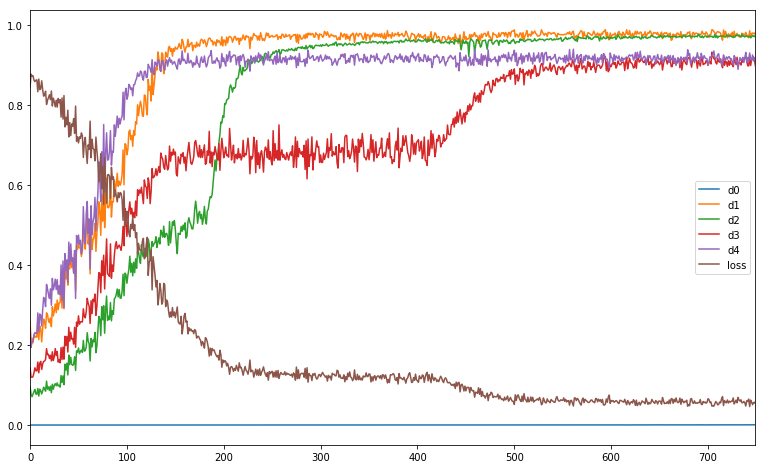

In [23]:
train_metrics.plot(figsize=(13, 8))

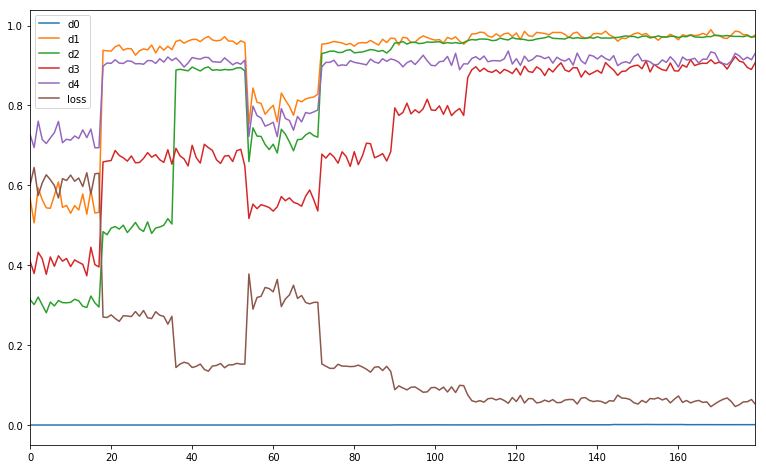

In [24]:
val_metrics.plot(figsize=(13, 8))

## Predict and visualize

In [18]:
torch.save(net, 'models/torch1')

/root/.pyenv/versions/3.6.0/lib/python3.6/site-packages/torch/serialization.py:147: UserWarning: Couldn't retrieve source code for container of type UNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/root/.pyenv/versions/3.6.0/lib/python3.6/site-packages/torch/serialization.py:147: UserWarning: Couldn't retrieve source code for container of type ConvBlock. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [19]:
test_net = net.cpu()

In [20]:
test_batch = next(iter(val_gen))
test_pred = net(npvar(test_batch[1], False))
test_pred_np = test_pred.cpu().data.numpy()

NameError: name 'val_gen' is not defined

In [ ]:
arr_to_img(test_batch[1][3][0])

In [ ]:
arr_to_img(test_pred_np[3][2])